In [1]:
from src.visualizer.painter import Plot, Font, plt

/home/rczx/miniconda3/envs/ntrain/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Painter Workspace

Using buildin function image
Using buildin function image


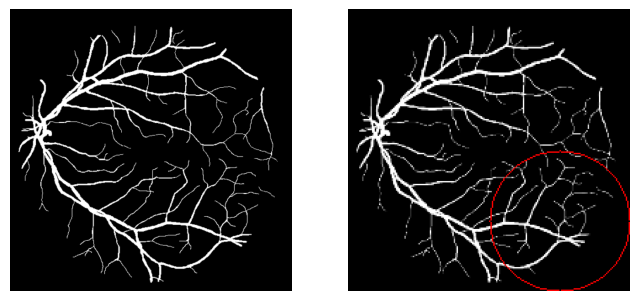

In [2]:
from src.utils.image_utils import ImageDrawer
from PIL import Image

image = Image.open("data/DRIVE/training/1st_manual/21.png").convert(mode="RGB")
image = image.resize((512, 512))

size = (100, 100)
xy = (100, 100)
ratio = 2
region = (*xy, *(xy[0] + size[0], xy[1] + size[1]))
resize = (size[0] * ratio, size[1] * ratio)
drawer = ImageDrawer(image).resize(resize)
center = (region[0] + region[2]) // 2, (region[1] + region[3]) // 2
radius = min(size) // 2
# o = drawer.draw_box(region, thickness=1).finish_as_opencv()
o = drawer.draw_circle(center, radius=radius, thickness=1).finish_as_opencv()

Plot(1, 2).subplot().image(image).complete().subplot().image(o).complete().show()
